In [15]:
!mkdir uci_bow
!mkdir uci_bow/train
!mkdir uci_bow/test
!mkdir multiwoz_batches

!git clone https://github.com/shoaib6174/MultiWOZ-Clustering/

!pip install bigartm10
!pip install kneed
!pip install pyclustering

Cloning into 'MultiWOZ-Clustering'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 57 (delta 30), reused 50 (delta 23), pack-reused 0
Unpacking objects: 100% (57/57), done.
     |████████████████████████████████| 2.0 MB 13.5 MB/s 
     |████████████████████████████████| 2.6 MB 13.7 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395122 sha256=9ba605f8da2db03728aca1ccf88d7ade2d3e109fd0d8a968a27435d2b9239ecb
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
Successfully built pyclustering


In [16]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import ast
import nltk
import string 
import artm

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

from pyclustering.utils import read_sample;
from pyclustering.cluster.dbscan import dbscan
from pyclustering.cluster.optics import optics, ordering_analyser, ordering_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer


# Utterance Representation 

I represented the utterances using tf-idf format. 

Steps: 



1.   Extracted the uttereances from json file of dialogues in a list(**utterances**) using **extract_texts()** function
2.   Cleaned the text using tokenization, lowercasing, punctuation and stop word removal, stripping, stemming and kept them in a list(**cleaned_texts**) using clean()  
3. In **get_tfidf()** function, used **sklearn.feature_extraction.text.TfidfVectorizer** to get the tf-idf of cleaned_texts.  **df** and **df_test** contains tf-idf of all the utterances of train and test folder of dialogues. So this df and df_test contains the tf-idf representation of the utterances.
4. BIGARTM takes input in UCI BOW/Vowpal Wabbit format only. So I saved the tf-idf data in UCI BOW format  ( **docword.multiwoz.txt**, **vocab.multiwoz.txt**) using **get_uci_bow()**. I saved the train and test data in different folders (uci_bow/train, uci_bow/test). Then I ran topic modeling using BIGARTM.



In [17]:
def extract_utterance(data):
    """
    Description: Returns a list of utterances from single json file
    Params: 
        data: json file of dialogue data
    """
    texts = []
    for item in data:
        for turn in item['turns']:

            text = turn['utterance']
            texts.append(text)
    return texts
def extract_texts(path):
    """
    Description: Returns a list of utterances extacted from folder of json file of dialogues

    Params:
      path: path of folder containing json file of dialogue data
    """   
    texts = []
    file_list = os.listdir(path)
    for file in file_list:
        with open(f'{path}/{file}') as f:
            data = json.load(f)
            texts += (extract_utterance(data))
    return texts
            


In [18]:
def clean(text):
  """
  Description: Returns cleaned text
  Params: 
    text: text to be cleaned
  """
  tokens = nltk.tokenize.word_tokenize(text)
  tokens = [w.lower() for w in tokens]
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  words = [word for word in stripped if word.isalpha()]
  words = [w for w in words if not w in stop_words]
  

  stemmed_words = [stemmer.stem(word) for word in words]
  sentence = " ".join(stemmed_words)
  return sentence

In [19]:
nltk.download("stopwords")
nltk.download('punkt')

stop_words = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Cleaning and TF-IDF


In [20]:
# extract utterances from json files 
def get_tfidf(path):
    """
    Description: Returns dataframe of all the files of specified folder in tf-idf format.
    """
    utterances = extract_texts(path)

    # clean the utterances
    cleaned_texts = []
    for utterance in utterances:
      cleaned_texts.append(clean(utterance))

    tfidf = TfidfVectorizer()

    response = tfidf.fit_transform(cleaned_texts)

    return pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())




*   For working with the whole dataset set **path="train"**
*   For experimenting with a smaller dataset set **path="sample"**




In [21]:
path="train"
df = get_tfidf(f"MultiWOZ-Clustering/{path}")
df_test = get_tfidf("MultiWOZ-Clustering/test")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# UCI Bag of Words Format

In [22]:
def get_uci_bow(dir, df):
  """
  Description: Writes the files in uci_bow/{dir} UCI BOW format from dataframe.
  """
  D = len(df.index)
  W = len(df.columns)
  C = np.count_nonzero(df)
  print(D, W, C)
  with open(f'uci_bow/{dir}/docword.multiwoz.txt', 'w') as docword:
    docword.write(f"{D}\n{W}\n{C}\n")
    for docID , row in df.iterrows():
      for wordID , val in enumerate(row):
        if val > 0:
          docword.write(f"{docID } {wordID+1 } {val}\n")


  with open(f'uci_bow/{dir}/vocab.multiwoz.txt', 'w') as vocab:
    for col in df.columns:
      vocab.write(f"{col}\n")

In [23]:
get_uci_bow("train", df)
get_uci_bow('test', df_test)

113552 4503 685983
14744 1793 90157


# Topic Modeling
**bold text**
I used artm model of BIGARTM for topic modeling. **topic_df** contains the topic informations (the utterances are in row wise and topics are in columns). I have also saved it in **topic_data.txt** file. 

In [24]:
batch_vectorizer = artm.BatchVectorizer(data_path='/content/uci_bow/train', data_format='bow_uci',
                                        collection_name='multiwoz', target_folder='multiwoz_batches')
batch_vectorizer_test = artm.BatchVectorizer(data_path='/content/uci_bow/test', data_format='bow_uci',
                                        collection_name='multiwoz', target_folder='multiwoz_batches')
                                        

### Perplexity Score

A lower perplexity score indicates better generalization performance.

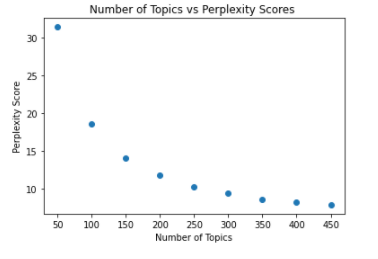

From the graph, I feel choosing num_topics = 250 will give a good fit.

In [25]:
# Choose parameters
num_topics = 250
num_collection_passes = 10
scores= []
cache_theta  = True

model = artm.ARTM(num_topics=num_topics, dictionary=batch_vectorizer.dictionary, cache_theta = cache_theta ,
                  regularizers = [artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhiRegularizer')],
                  scores=[artm.TopTokensScore(name='top_tokens_score')])

model.scores.add(artm.PerplexityScore(name='my_first_perplexity_score',
                                      dictionary=batch_vectorizer_test.dictionary))

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes= num_collection_passes)

model.score_tracker["my_first_perplexity_score"].value[-1]

# for the full dataset perplexity score is 10.41 for 250 topics

10.427356719970703

In [26]:
# with open('top_words_of_topics.txt', 'w') as file:
#     file.write(json.dumps(topics))

# with open('top_words_of_topics.json', 'w') as fp:
#     json.dump(topics, fp)

In [27]:
top_tokens = model.score_tracker['top_tokens_score']
topics = {}
for topic_name in model.topic_names:
    #print('\n', topic_name)
    topics[topic_name] = []
    for (token, weight) in zip(top_tokens.last_tokens[topic_name],
                               top_tokens.last_weights[topic_name]):
        #print(token, '-', weight)
        topics[topic_name].append(token)



In [28]:
# top_tokens = model.score_tracker['top_tokens_score']
# topics = {}
# for topic_name in model.topic_names:
#     #print('\n', topic_name)
#     topics[topic_name] = ""
#     for (token, weight) in zip(top_tokens.last_tokens[topic_name],
#                                top_tokens.last_weights[topic_name]):
#         #print(token, '-', weight)
#         topics[topic_name] += f"{token}, "

# df_topic = pd.DataFrame.from_dict(topics,orient='index')
# df_topic.to_csv("topic data.csv")

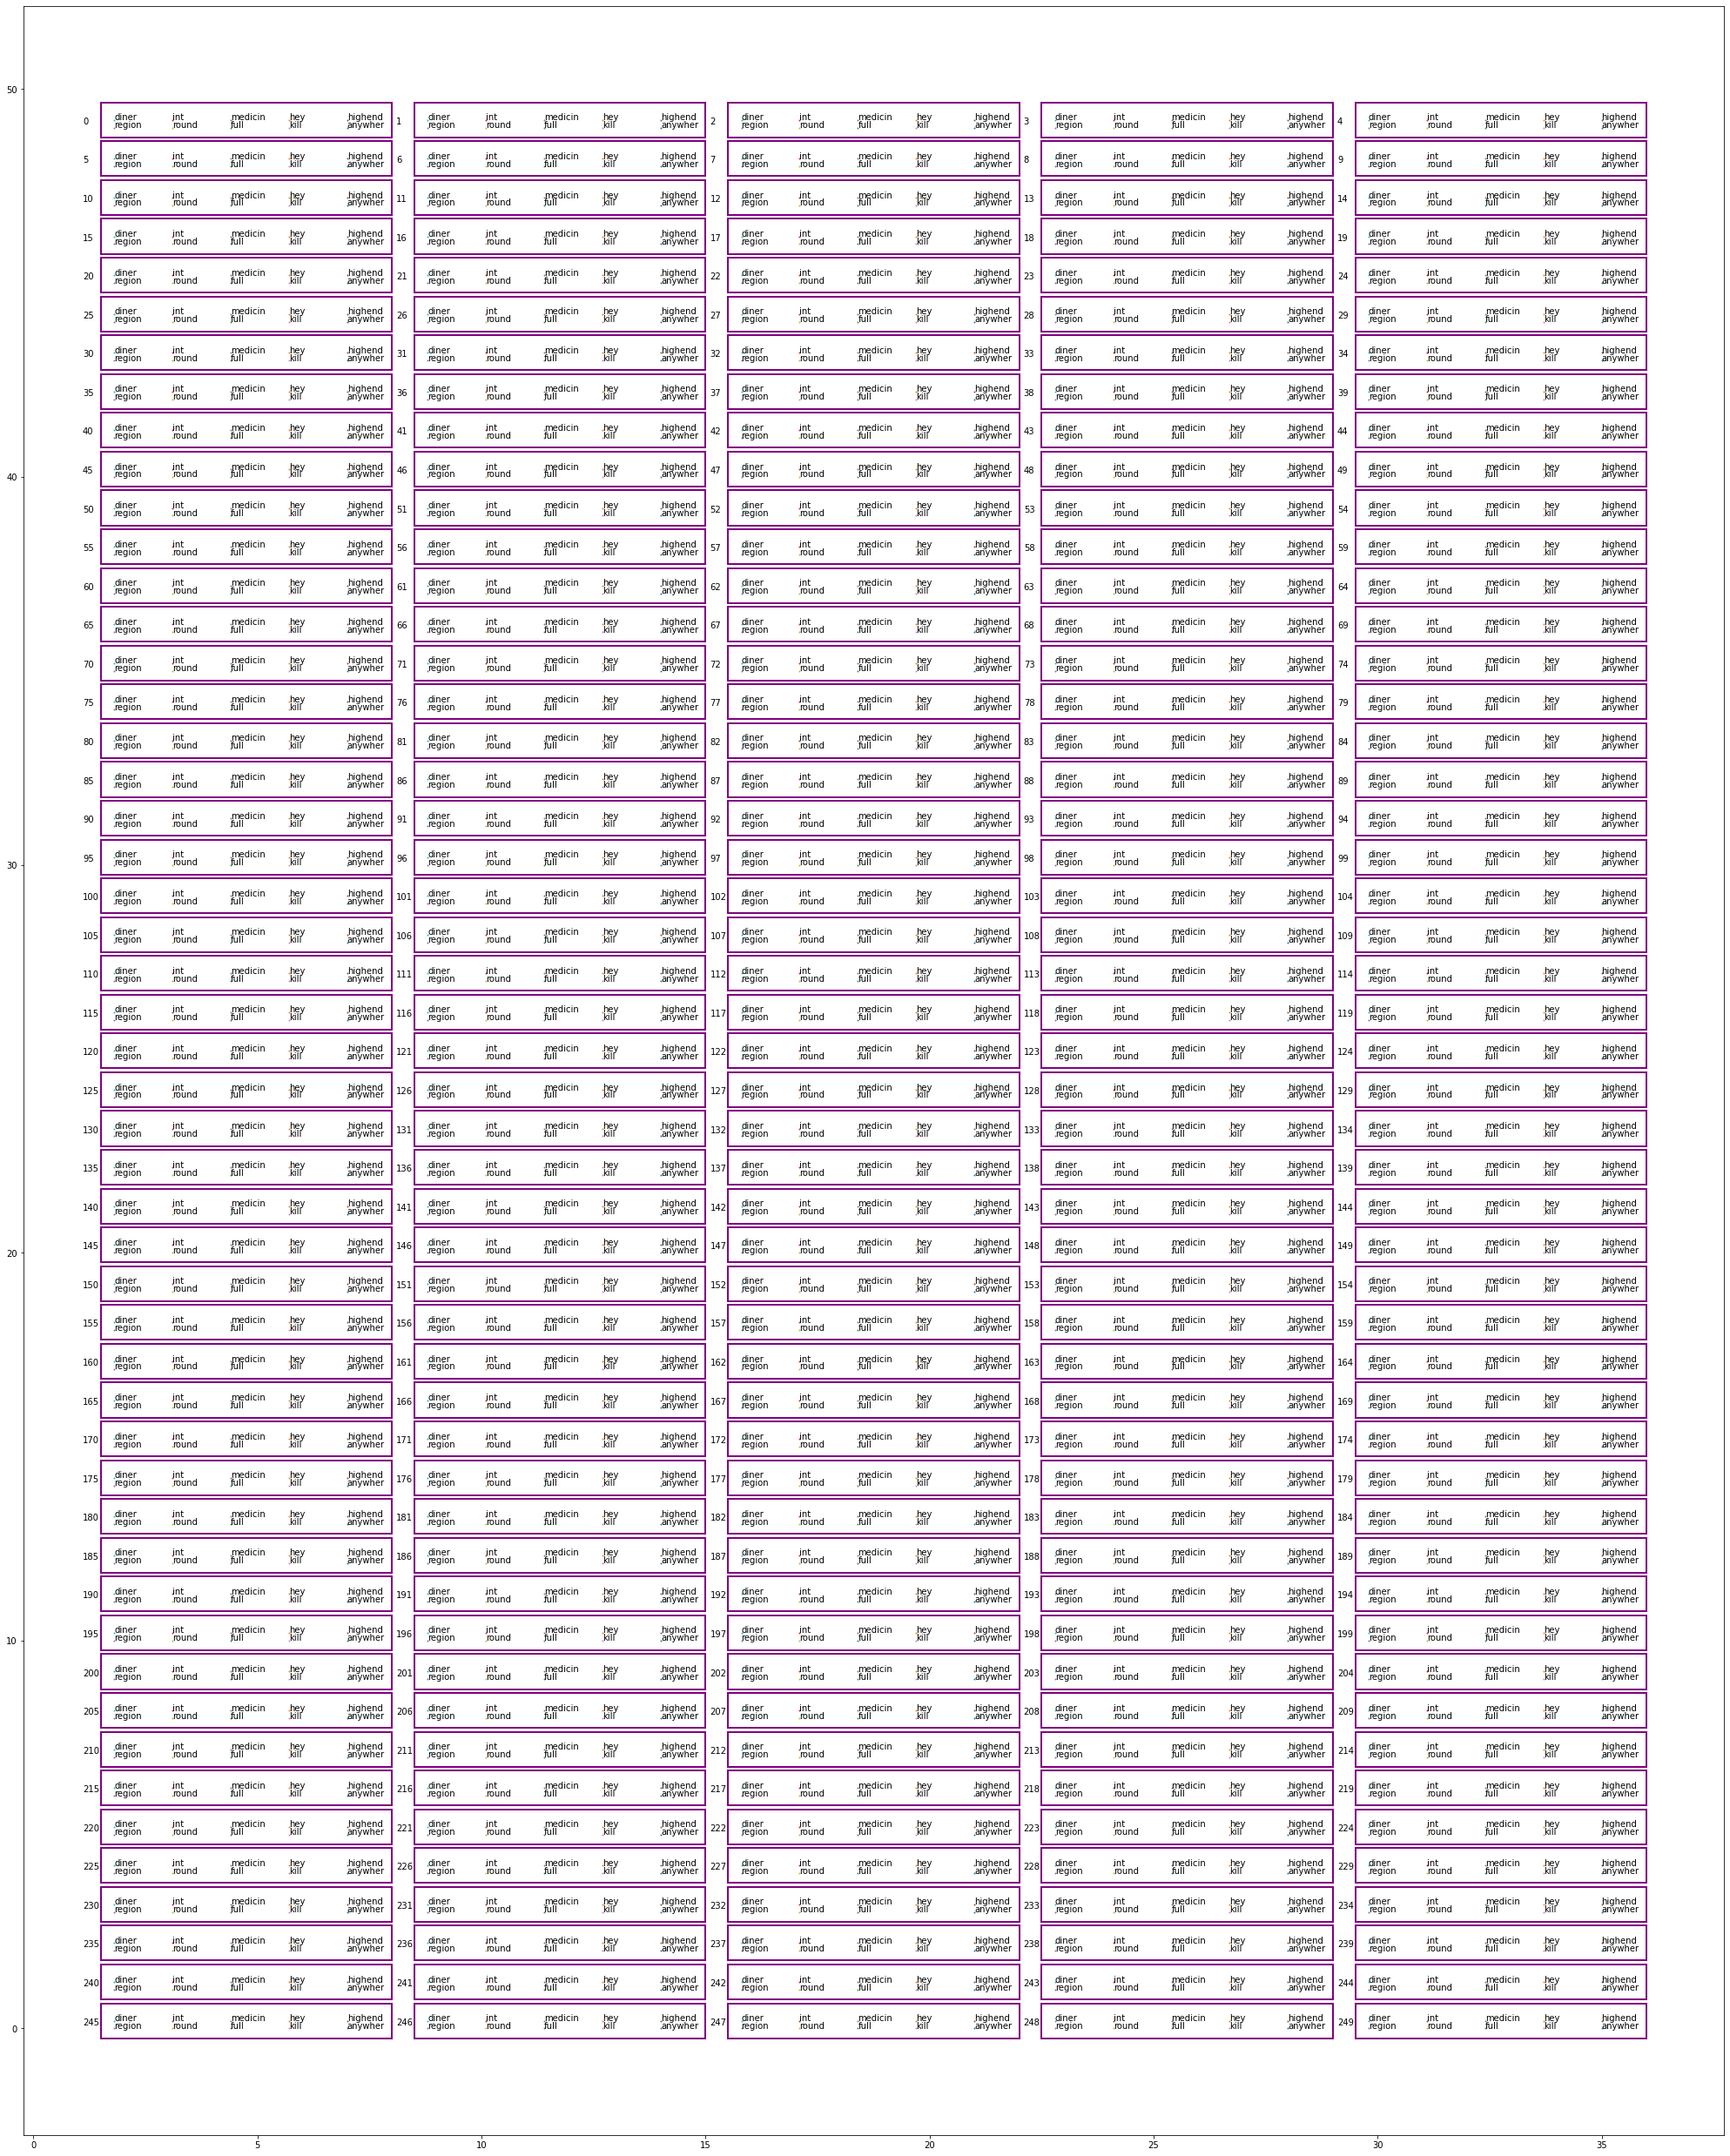

In [ ]:
plt.rcParams["figure.figsize"] = (35,45)
fig, ax = plt.subplots()

t = 0

for i in reversed(range(250)):
  topic = f'topic_{i}'
  text = topics[topic]
  if t == 250:
    break
  w = 0

  left, bottom, width, height = ( 29 - (7 * (t%5)-.5) , (t//5) - .25  , 6.5, .9)

  rect=mpatches.Rectangle((left,bottom),width,height, 
                          fill=False,
                          color="purple",
                        linewidth=2)
                        #facecolor="red")
  plt.gca().add_patch(rect)
  ax.annotate(topic[6:], (left-.4, bottom+.35))
  for text in texts:
    
    y = t// 5 + .2 * (w%2)
    x = 35 - (7 * (t%5) + (w % 5) * 1.3 )
    ax.scatter(x, y ,1)
    ax.annotate(text, (x,y))

    w += 1
  t += 1 
plt.savefig("topics word")

In [29]:
topic_df = model.get_theta().T


with open("topic_data.txt", 'w') as topic_data:
  for idx, row in topic_df.iterrows():
    for val in row:
      topic_data.write(f"{val} ")
    topic_data.write("\n")

# Read Topic Data

In [30]:
data = read_sample("topic_data.txt")

In [31]:
def show_hist(clusters, title):
  """
  Description: Shows a histogram of count of items in each clusters, No oftotoal clusters and 
                total count of items in the clusters
  Params: 
    clusters: a list containing the lists of items of each clusters
    titile: Name of the algorithom
  """
  names = list(f"{i+1}" for i in range(len(clusters)) )
  values = list(len(c) for c in clusters)
  print(f"Total Cluster: {len(clusters)} \nTotal count of uttarance in Clusters:{sum(values)}")
  y_pos = np.arange(len(clusters))

  plt.figure(figsize=(20,10))
  plt.bar(y_pos, values, align='center', alpha=0.5)
  plt.xticks(y_pos, names)
  plt.ylabel('Count')
  plt.title(title)

  plt.show()

# Clustering

# I am using Colab and not being able to use the whole dataset because of resource constrains. I am getting runtime erro. **I have calculated  the parameters using the whole dataset but trained the model using a smaller dataset.**

# DBSCAN

### Elbow
I didn't get any good distribution of clusters using the elbow value.



NB: Following knee value is calculated using a smaller dataset of 14k utterances. For the whole dataset I got 0.33 to be the knee value. 

0.332798375508411


<Figure size 360x360 with 0 Axes>

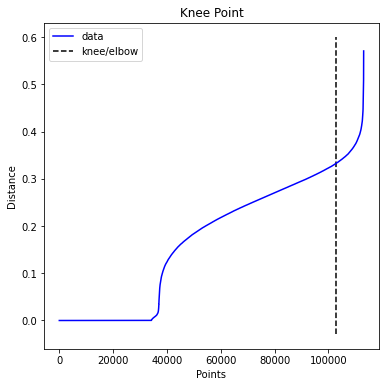

In [ ]:
from kneed import KneeLocator

n_neighbors = 50
nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors = nearest_neighbors.fit(data)

distances, indices = neighbors.kneighbors(data)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

NB: Following model is trained on a smaller data set (around 14k utterences) and it classified around 5k utterences as outliers and around 8k utterances in one class. 

In [ ]:
eps = 0.4
neighbors = 50

dbscan_instance = dbscan(data, eps, neighbors);
dbscan_instance.process();
clusters = dbscan_instance.get_clusters();

#histogram
show_hist(clusters, "DBSCAN")


# Optics

To find the optimum number of clusters I used Distortion and Silhouette Score Elbow for KMeans Clustering.  

Using values [100, 200, 300, 400, 500] I got elbow at 200 using Distortion Score. 
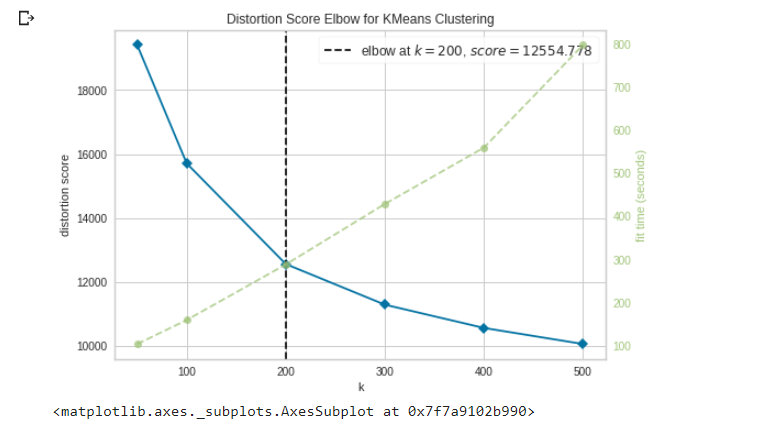


So then I tried using [50,75,100,125,150,175,200,225] and got elbow at 125 for distortion. 
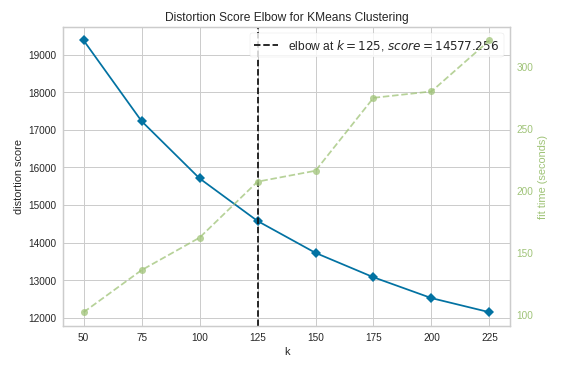

Then I used values [50,75,100,125,150,175,200,225] for Silhouette and got elbow at again at 125. 
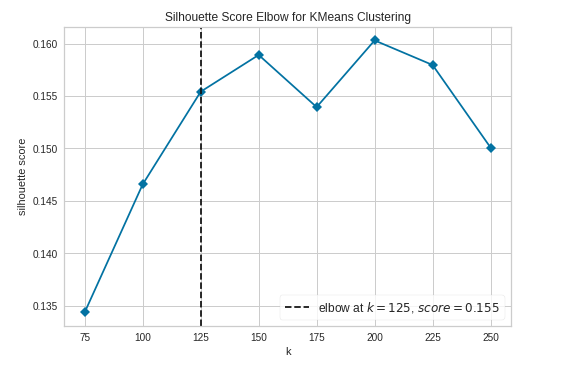


I have used amount_clusters to be 125 for optics and Xmeans



NB: Following model is trained on a smaller data set (around 14k utterences) and  it classified 10k utterences as outliers

In [ ]:
eps = 0.4
minpts= 10
amount_clusters = 125

optics_instance = optics(data,eps =eps, minpts = minpts, amount_clusters = amount_clusters)
optics_instance.process()
 
# Obtain results of clustering
clusters = optics_instance.get_clusters()

#histogram
show_hist(clusters, "Optics")


# XMEANS

NB: The following model is trained on the whole dataset (113k utterences)

Total WCE: 17386.901524165867
Total Cluster: 125 
Total count of uttarance in Clusters:113137


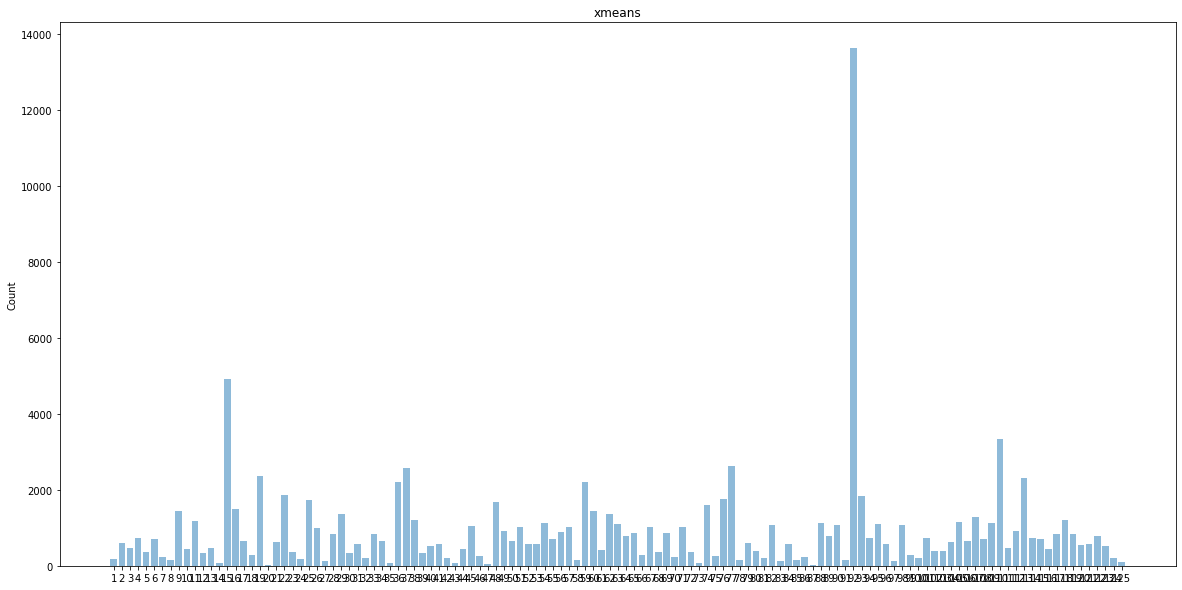

In [32]:
amount_initial_centers = 30
number_of_clusters = 125
initial_centers = kmeans_plusplus_initializer(data, amount_initial_centers).initialize()
 
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is number_of_clusters.
xmeans_instance = xmeans(data, initial_centers, number_of_clusters)
xmeans_instance.process()
 
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
 
# Print total sum of metric errors
print("Total WCE:", xmeans_instance.get_total_wce())
 
#histogram
show_hist(clusters, "xmeans")

In [46]:
network = []
no_clusters = 125
no_topics = 250
for source, center in enumerate(centers[:no_clusters]):
  center = center[:no_topics]
  for node, dist in enumerate(center):
    if dist > 0:
      network.append([f"{source}", f"topic_{node}",dist])



## Visualizing 

In [34]:
from bokeh.io import output_notebook, show, save
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
import networkx
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap
from networkx.algorithms import community
import networkx as nx

In [47]:
df = pd.DataFrame(network, columns=["Source", "Target", "Weight"])
df

,Source,Target,Weight
0,0,topic_1,5.938782e-04
1,0,topic_2,1.241071e-03
2,0,topic_8,1.810366e-03
3,0,topic_11,3.211494e-03
4,0,topic_17,4.866474e-03
...,...,...,...
19423,123,topic_242,2.168129e-13
19424,123,topic_244,2.081582e-03
19425,123,topic_246,2.078017e-03
19426,123,topic_247,1.030134e-02


In [48]:
output_notebook()
G = nx.from_pandas_edgelist(df, 'Source', 'Target', 'Weight')
fig = plt.figure(1, figsize=(200, 80), dpi=60)


<Figure size 12000x4800 with 0 Axes>

In [49]:
degrees = dict(networkx.degree(G))
networkx.set_node_attributes(G, name='degree', values=degrees)

number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in networkx.degree(G)])
networkx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

In [50]:
modularity_class = {}
modularity_color = {}

for i in range(no_clusters):
  modularity_class[f"{i}"] = 1
  modularity_color[f"{i}"] = "#66c2a5"
for i in range(no_topics):
  modularity_class[f"topic_{i}"] = 2
  modularity_color[f"topic_{i}"] = "#3288bd"

# Add modularity class and color as attributes from the network above
networkx.set_node_attributes(G, modularity_class, 'modularity_class')
networkx.set_node_attributes(G, modularity_color, 'modularity_color')

In [51]:
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'modularity_color'
#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8
#Choose a title!
title = 'Topic Network'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Character", "@index"),
        ("Degree", "@degree"),
         ("Modularity Class", "@modularity_class"),
        ("Modularity Color", "$color[swatch]:modularity_color"),
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset, tap", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object

network_graph = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

plot.renderers.append(network_graph)

show(plot)
save(plot, filename=f"{title}.html")

/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/content/Topic Network.html'

# Saving Data in Table

In [52]:
df.set_index(["Source"])
cluster_data = pd.pivot_table(df, values='Weight', index=['Source'],
                    columns=['Target'])
cluster_data

Target,topic_0,topic_1,topic_10,topic_100,topic_101,topic_102,topic_103,topic_104,topic_105,topic_106,topic_107,topic_108,topic_109,topic_11,topic_110,topic_111,topic_112,topic_113,topic_114,topic_115,topic_116,topic_117,topic_118,topic_119,topic_12,topic_120,topic_121,topic_122,topic_123,topic_124,topic_125,topic_126,topic_127,topic_128,topic_129,topic_13,topic_130,topic_131,topic_132,topic_133,...,topic_63,topic_64,topic_65,topic_66,topic_67,topic_68,topic_69,topic_7,topic_70,topic_71,topic_72,topic_73,topic_74,topic_75,topic_76,topic_77,topic_78,topic_79,topic_8,topic_80,topic_81,topic_82,topic_83,topic_84,topic_85,topic_86,topic_87,topic_88,topic_89,topic_9,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
Source,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,0.000594,NaN,NaN,NaN,NaN,0.016327,NaN,NaN,0.013031,NaN,NaN,1.117950e-02,0.003211,NaN,NaN,0.001277,NaN,0.326330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.032611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.877897e-04,NaN,NaN,0.003388,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002794,NaN,NaN,0.007991,NaN,NaN,NaN,NaN,NaN,0.001810,0.009535,NaN,NaN,NaN,NaN,NaN,NaN,0.053564,NaN,0.001225,NaN,0.001139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.004729,0.002631,0.000636,0.001064,NaN,0.007622,NaN,0.002281,0.028641,NaN,NaN,2.959302e-02,0.000630,NaN,NaN,NaN,0.000198,0.068423,NaN,0.000113,0.000395,0.001805,2.969668e-04,NaN,0.000399,0.051038,NaN,0.000243,1.386003e-14,0.000356,2.349584e-11,0.000639,0.000603,1.658524e-03,NaN,NaN,NaN,0.000205,0.009146,...,NaN,NaN,NaN,0.000010,0.000972,NaN,0.000180,0.001014,0.000244,0.002339,5.178012e-12,NaN,0.031858,0.000539,0.000655,0.000187,0.000424,0.000777,NaN,0.011626,0.000730,NaN,0.000193,0.000414,NaN,NaN,0.023841,NaN,0.000266,NaN,0.007092,0.000246,NaN,0.002740,0.000313,2.087041e-19,NaN,NaN,0.000232,0.000270
10,0.005382,0.004561,0.003947,0.000323,0.007967,0.000840,0.000670,3.046452e-04,0.006209,0.001111,2.086923e-03,0.008800,5.594715e-17,0.003265,0.000939,0.001470,0.000593,0.002799,0.000494,0.014796,0.030181,0.001939,0.004034,NaN,0.003406,0.000750,0.004616,0.006141,0.004138,2.941352e-14,0.011503,6.606237e-12,0.017573,0.014405,1.637380e-04,0.006922,0.016327,0.000776,NaN,0.000061,...,0.000252,1.185205e-02,0.008221,0.000763,0.005063,0.000475,0.033940,0.000117,0.000096,0.006116,1.676335e-04,0.000648,0.000195,0.001058,0.000999,0.001197,0.005606,0.004317,0.000570,0.000189,0.002591,0.011185,0.000780,0.000618,0.002896,0.000800,0.000174,0.014395,0.001340,0.007566,0.001399,0.000169,0.000412,0.003896,0.000738,2.046053e-05,0.002025,8.016861e-05,0.000095,NaN
100,0.000409,0.001695,0.002661,0.000408,0.009010,0.000380,NaN,NaN,0.005239,0.002130,4.086820e-12,0.000343,5.395550e-04,0.001476,0.003399,0.001552,0.002231,0.004495,0.000168,0.023569,0.010438,NaN,0.001054,3.871576e-19,0.000314,NaN,0.001709,0.000285,NaN,3.490647e-15,0.026655,3.304596e-12,0.001276,0.001195,4.234479e-04,NaN,0.011522,0.001127,0.000762,0.000143,...,NaN,1.042586e-02,0.001256,0.000022,0.000197,NaN,0.007032,0.000123,NaN,0.018978,2.531231e-11,0.000734,0.000175,0.003575,NaN,0.000444,0.001657,0.003586,NaN,NaN,0.000407,0.004976,0.003240,0.000252,0.000458,0.001743,0.000178,0.002154,0.001061,0.001712,NaN,0.007973,NaN,0.001571,0.001517,5.301696e-10,0.000780,NaN,NaN,0.011069
101,0.004411,0.001860,0.005348,0.000768,0.010002,0.006989,NaN,1.632923e-03,0.010382,0.001893,2.137360e-04,0.003594,7.189439e-04,0.001238,0.003421,0.000580,0.001543,0.002329,0.001206,0.004639,0.020530,NaN,0.002513,3.113544e-19,NaN,0.001038,0.002691,0.000577,0.000770,1.176921e-12,0.006439,8.518373e-10,0.005218,0.008921,6.748090e-05,0.029924,0.036750,NaN,NaN,0.004075,...,NaN,3.385771e-02,0.002736,0.000017,0.002244,NaN,0.023394,0.000734,NaN,0.004384,3.917135e-04,0.002417,NaN,0.000562,0.000491,0.001690,0.003133,0.011229,0.000991,NaN,0.002608,0.356197,0.003617,NaN,0.005248,0.000278,0.000723,0.002353,0.000541,0.001434,0.000625,0.001632,NaN,0.005206,NaN,6.736612e-04,0.001397,3.89772

In [ ]:
# cluster_data.to_csv("cluster_data.csv")
# result = cluster_data.to_json(orient="index")
# parsed = json.loads(result)
# json.dumps(parsed, indent=4)  
# with open('cluster_data.json', 'w') as fp:
#     json.dump(parsed, fp)